# NSRDB

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nsrdb_dir = os.listdir("dataset/NSRDB")
nsrdb_dir

['16265',
 '16272',
 '16273',
 '16420',
 '16483',
 '16539',
 '16773',
 '16786',
 '16795',
 '17052',
 '17453',
 '18177',
 '18184',
 '19088',
 '19090',
 '19093',
 '19140',
 '19830']

In [3]:
len(nsrdb_dir)

18

In [4]:
record = nsrdb_dir[0]

print(record)

16265


In [5]:
dataset_dir = "dataset/NSRDB/%s/" % record 

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)
        
csv_filenames

['samples.csv']

- Read & formatting ECG data

In [6]:
def read_csv_to_df(filename, folder, sep=","):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG1', 'ECG2']

    df['ECG1'] = pd.to_numeric(df['ECG1'])
    df['ECG2'] = pd.to_numeric(df['ECG2'])
    
    # peak reduction
    df[df['ECG1'] > 2] = 2
    df[df['ECG1'] < -2] = -2
    df[df['ECG2'] > 2] = 2
    df[df['ECG2'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

In [7]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - samples.csv
[INFO] finish data cleansing - samples.csv
[INFO] finish time cleansing -  samples.csv


In [8]:
df_ecg.head(10)

,ECG1,ECG2
Time,,
2021-01-22 08:04:00.000,-0.165,-0.325
2021-01-22 08:04:00.008,-0.155,-0.325
2021-01-22 08:04:00.016,-0.195,-0.305
2021-01-22 08:04:00.023,-0.205,-0.305
2021-01-22 08:04:00.031,-0.185,-0.295
2021-01-22 08:04:00.039,-0.155,-0.265
2021-01-22 08:04:00.047,-0.135,-0.235
2021-01-22 08:04:00.055,-0.095,-0.185
2021-01-22 08:04:00.063,-0.075,-0.135


- plot signal 

In [9]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    
    plt.ylim([-2.1, 2.1])
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

In [10]:
fs = 128 #hz ---> https://physionet.org/lightwave/?db=nsrdb/1.0.0

08:04:00 08:04:16


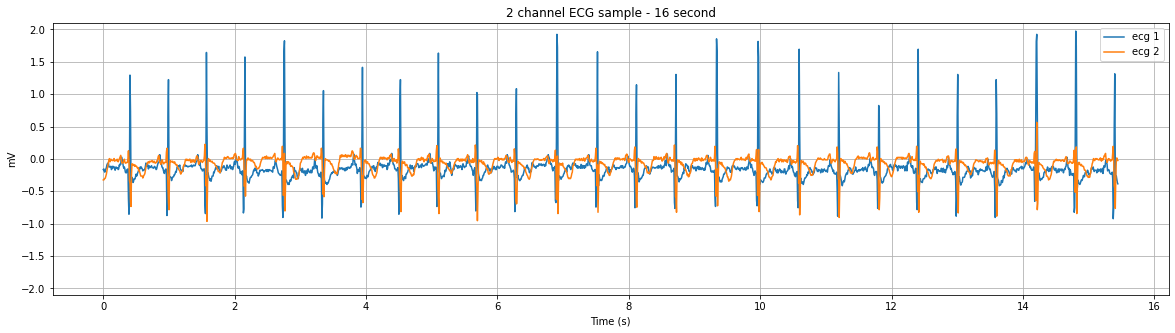

In [11]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "2 channel ECG sample - 16 second")

- split each dataframe to 16s sequence and apply Baseline Removal 

In [12]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [13]:
def plot_16s_sample(data, label="2 channel ECG plot - 16s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["ecg1", "ecg2"])
    plt.grid(True)
    plt.show()

In [14]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [15]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [16]:
time_interval = []
if len(df_ecg) > 0:
    intr = [time_result for time_result in perdelta(df_ecg.index[0], df_ecg.index[-1], timedelta(seconds=16))]
    time_interval.append(intr)

In [17]:
ECG_ALS = []
ECG_ALS_label = []

for tm_int in time_interval :
    for time_intv in list(zip(tm_int, tm_int[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('N')

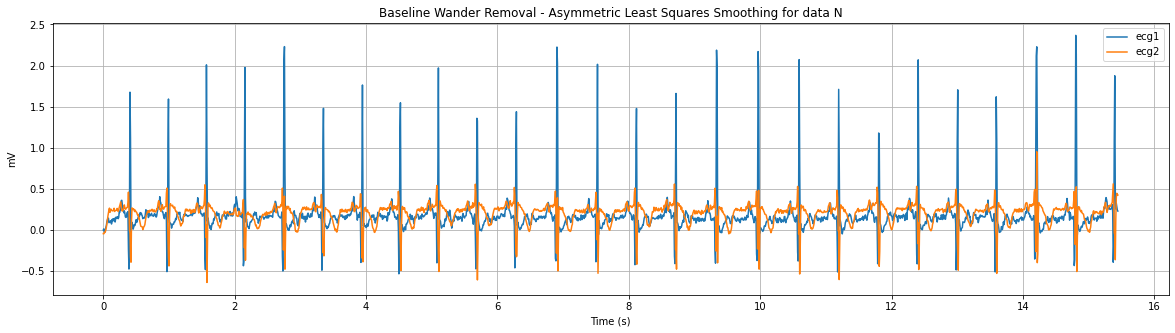

In [18]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

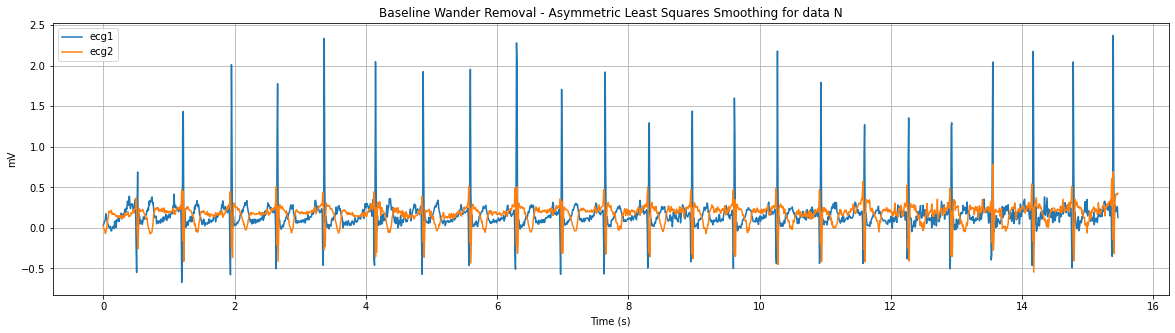

In [19]:
idx = -1
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

- Signal normalization from -1 to 1

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [21]:
#scaler = scaler = StandardScaler(with_mean=False, with_std=False) 
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

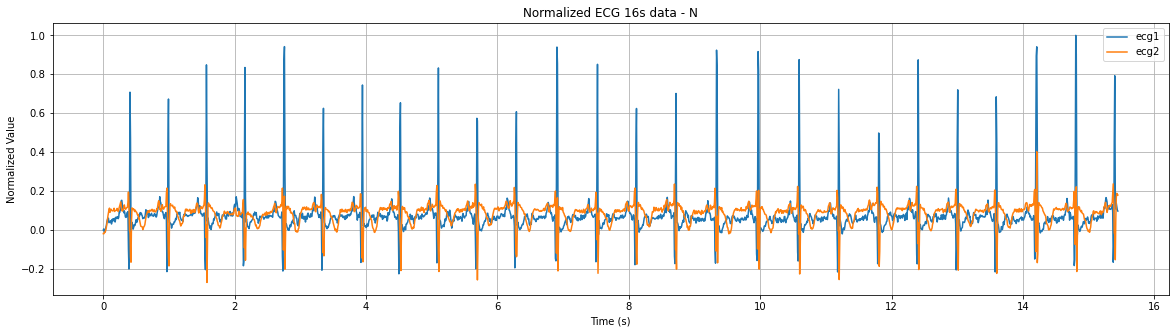

In [22]:
idx = 0
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

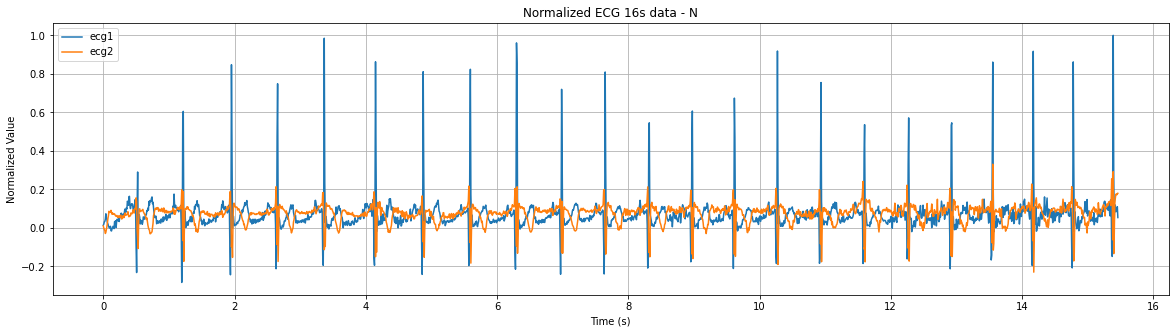

In [23]:
idx = -1
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

- Upsampling (128Hz to 250Hz)

In [24]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [25]:
new_fs = 250 # Hz 
ECG_ALS_Norm_Up = []
for data in ECG_ALS_Norm :
    data1 = np.array(data[0][:,0])
    data2 = np.array(data[1][:,0])
    data1 = upsampling_twice(data1) 
    data2 = upsampling_twice(data2) 
    ECG_ALS_Norm_Up.append([data1, data2])

- QRS Detection

In [26]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [27]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

- Test R peak detector - Christov

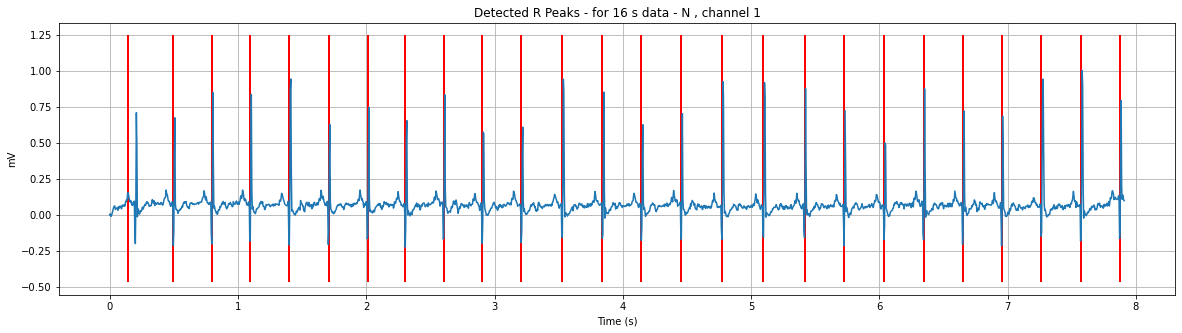

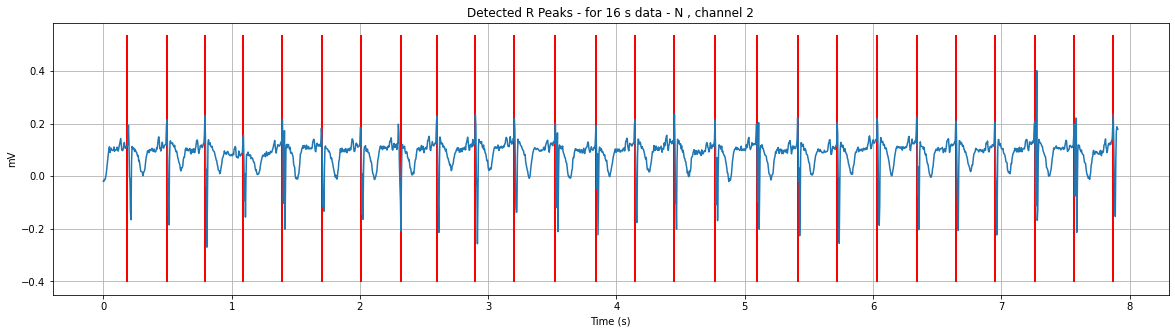

In [28]:
idx = 0

data = np.array(ECG_ALS_Norm[idx])

for ch in range(0,2):
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], new_fs, label="Detected R Peaks - for 16 s data - %s , channel %d" % (ECG_ALS_label[idx], ch + 1))

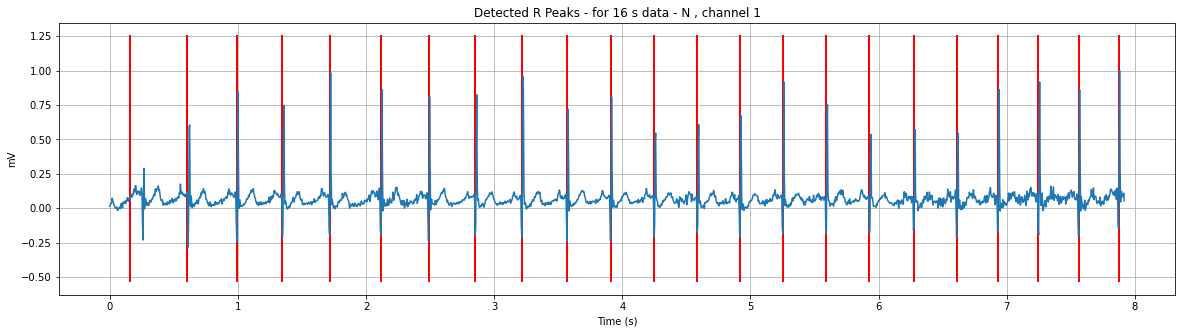

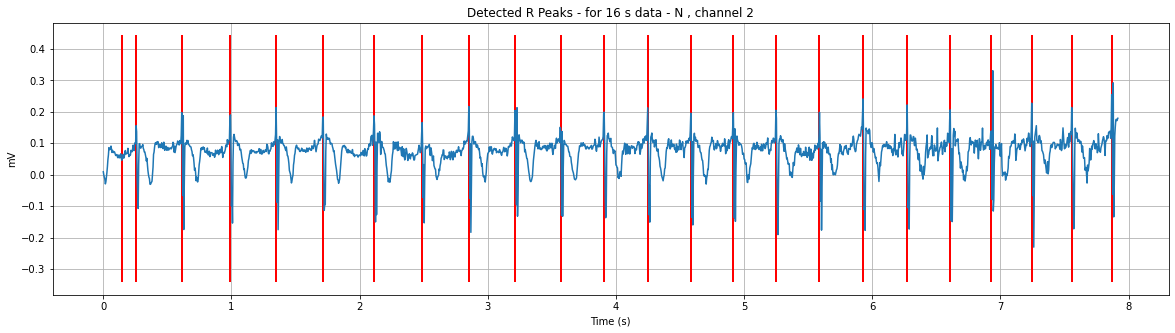

In [29]:
idx = -1

data = np.array(ECG_ALS_Norm[idx])

for ch in [0, 1]:
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], new_fs, label="Detected R Peaks - for 16 s data - %s , channel %d" % (ECG_ALS_label[idx], ch + 1))

- Split each 16s to 1.2 x R-R sequence
- Padding the sequence with zero for length 300 point

In [30]:
ECG_split = []
ECG_split_label = []
for i in range(len(ECG_ALS_Norm_Up)) :
    data = np.array(ECG_ALS_Norm_Up[i])
    if len(data) > 0:
        r_peaks = []
        try :
            r_peaks = detectors.christov_detector(data[0])
        except :
            print("cannot find R peaks in ALS Norm, idx %d" % i)
        RRs = np.diff(r_peaks)
        RRs_med = np.median(RRs)
        if not np.isnan(RRs_med) and RRs_med > 0:
            for rp in r_peaks :
                split1 = data[0][rp : rp + int(RRs_med * 1.2)] 
                split2 = data[1][rp : rp + int(RRs_med * 1.2)] 
                
                n1 = len(split1) if len(split1) <= 300 else 300
                n2 = len(split2) if len(split2) <= 300 else 300
                pad1 = np.zeros(300)
                pad2 = np.copy(pad1)
                pad1[0:n1] = split1[0:n1]
                pad2[0:n2] = split2[0:n2]
                ECG_split.append([pad1, pad2])
                ECG_split_label.append(ECG_ALS_label[i])


In [31]:
def plot_1_sample(data, label, fs):
    ecg1 = data[0]
    ecg2 = data[1]
    times = np.arange(ecg1.shape[0]) / fs * 1000 

    label = 'Normal' if label == 'N' else 'Atrial Fibrillation'
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title("Plot 1 Sample (%dHz) : %s Beat" % (fs, label))
    plt.xlabel("Time (ms)")
    plt.ylabel("mV")
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

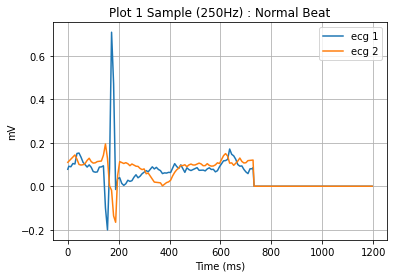

In [32]:
idx = 0
plot_1_sample(ECG_split[idx], ECG_split_label[idx], new_fs)

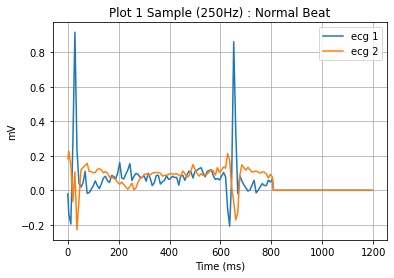

In [33]:
idx = -3
plot_1_sample(ECG_split[idx], ECG_split_label[idx], new_fs)

In [34]:
data = []
for i in range(len(ECG_split)):
    x = list(ECG_split[i][0])
    x.extend(list(ECG_split[i][1]))
    x.append(ECG_split_label[i])
    data.append(x)

In [35]:
ECG = pd.DataFrame(data)

In [36]:
ECG.tail()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
2317,-0.023014,-0.117769,-0.212523,-0.128232,-0.043941,0.244687,0.533316,0.539487,0.545659,0.271487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2318,-0.055135,-0.166729,-0.154076,-0.141423,0.096633,0.334689,0.597955,0.861221,0.521710,0.182198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2319,-0.021254,-0.136896,-0.166227,-0.195559,0.040545,0.276649,0.596962,0.917275,0.577906,0.238536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2320,-0.106704,-0.157305,-0.207907,-0.068939,0.070028,0.466006,0.861985,0.602493,0.343001,0.161407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2321,0.009127,-0.109396,-0.128892,-0.148388,0.072334,0.293057,0.646529,1.000000,0.634850,0.269700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [37]:
ECG.to_csv("dataset/NSRDB_%s_sequence_300_pt_2_ch.csv" % record, index=False, header=False)